This notebook finds the time spent at berth lying still for tankers. It does not save any of the data to a file, so you will have to do that yourself after you run the notebook. At the end the dataframe called berth_stays_merged contains the information. 

In [76]:
import pandas as pd
import glob #For combining individual files into one dataframe
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display #For better display of high dimension dataframes. 
from matplotlib.patches import Patch
import matplotlib.cm as cm
from shapely.geometry import Point
from tqdm import tqdm #progress bar
import numpy as np
import movingpandas as mp
from datetime import timedelta

Note: MovingPandas is not available through Anaconda Navigator and has to be installed via command prompt. IT Group Policies restricts this to an extent. I managed do to it by activating admin priviliges via Heimdal Agent and then running command prompt as administrator (right-click). This allowed me to install it - Alternatively ask IT for help on how to get admin access on command prompt. 

In [77]:
#Set pandas options to display all columns without collapsing
pd.set_option('display.max_columns', None)  #No column limit
pd.set_option('display.width', None)  #Auto-width adjustment
pd.set_option('display.max_rows', None)  #You can adjust the number of rows displayed


Below block loads the port outline geojson file, which is manually drawn on the geojson.io website. Likewise the berth bounding boxes are drawn on this website. The berths were detected using the pdf map available via this link: https://www.valenciaport.com/en/port-authority-valencia/infrastructure/port-terminals-facilities/port-of-valencia/

In [78]:
#Load the port outline geoJSON file
port = gpd.read_file(Path("data/Port_Valencia_Outline.geojson"))

#Load the berth bounding boxes
tanker_berths = gpd.read_file(Path("data/Tanker_Terminal_Berths.geojson"))
tanker_union = tanker_berths.unary_union
solid_bulk_berths = gpd.read_file(Path("data/Solid_Bulk_berth.geojson"))
RoRo_berths = gpd.read_file(Path("data/Ro-ro_and_Vehicle_berth.geojson"))
Passenger_berths = gpd.read_file(Path("data/Passenger_berth.geojson"))
General_cargo_berths = gpd.read_file(Path("data/General_Cargo_berth.geojson"))
Container_berths = gpd.read_file(Path("data/Container_berth.geojson"))



Plots the port and berth bounding boxes 

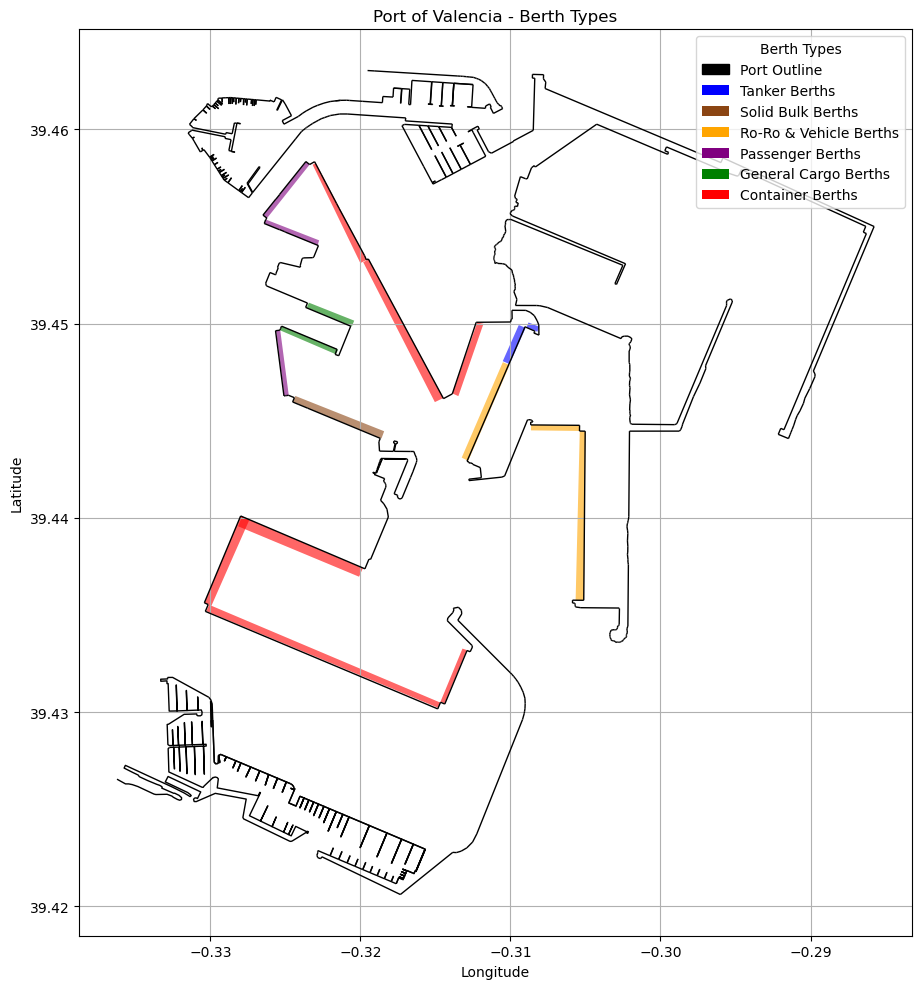

In [79]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the port outline
port.plot(ax=ax, color='black', edgecolor='black', linewidth=1)

# Plot each berth type with a unique color
tanker_berths.plot(ax=ax, color='blue', alpha=0.6)
solid_bulk_berths.plot(ax=ax, color='saddlebrown', alpha=0.6)
RoRo_berths.plot(ax=ax, color='orange', alpha=0.6)
Passenger_berths.plot(ax=ax, color='purple', alpha=0.6)
General_cargo_berths.plot(ax=ax, color='green', alpha=0.6)
Container_berths.plot(ax=ax, color='red', alpha=0.6)

# Create custom legend
legend_elements = [
    Patch(facecolor='black', edgecolor='black', label='Port Outline'),
    Patch(facecolor='blue', label='Tanker Berths'),
    Patch(facecolor='saddlebrown', label='Solid Bulk Berths'),
    Patch(facecolor='orange', label='Ro-Ro & Vehicle Berths'),
    Patch(facecolor='purple', label='Passenger Berths'),
    Patch(facecolor='green', label='General Cargo Berths'),
    Patch(facecolor='red', label='Container Berths')
]

# Add labels and legend
ax.set_title("Port of Valencia - Berth Types")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(handles=legend_elements, title="Berth Types", loc='best')
ax.grid(True)

plt.tight_layout()
plt.show()

## Load AIS data

The AIS data we use is the data received from Awake. It is AIS that has been processed by Awake during their internal processes and augmented by additional ship specific data, such as size, weight, classification society etc. This means that some positions might have been removed due to a cleaning process, as raw AIS data requires some cleaning due to noisy data. This means that if we try to plot positions with connecting lines we might see lines crossing land since positions in between might have been removed. 


In [80]:
#Define the folder and file pattern
folder = Path("data/mission-voyage-examples")
file_list_arrivals_AIS = list(folder.glob("ESVLC-arrivals-voyage-ais-data-*.parquet.gzip"))
file_list_arrivals_meta = list(folder.glob("ESVLC-arrivals-voyage-metadata-*.parquet.gzip"))
file_list_departures_AIS = list(folder.glob("ESVLC-departures-voyage-ais-data-*.parquet.gzip"))
file_list_departures_meta = list(folder.glob("ESVLC-departures-voyage-metadata-*.parquet.gzip"))

#Create Dataframes of the file types
Arrivals_AIS = pd.concat([pd.read_parquet(file) for file in file_list_arrivals_AIS], ignore_index=True)
Arrivals_Meta = pd.concat([pd.read_parquet(file) for file in file_list_arrivals_meta], ignore_index=True)
Departures_AIS = pd.concat([pd.read_parquet(file) for file in file_list_departures_AIS], ignore_index=True)
Departures_Meta = pd.concat([pd.read_parquet(file) for file in file_list_departures_meta], ignore_index=True)

In [81]:
display(Arrivals_AIS.head())

,voyage_id,voyage_status,mmsi,pos_timestamp,navigation_status,position_accuracy,longitude,latitude,course_over_ground,true_heading,timestamp_seconds,raim,rate_of_turn,speed_over_ground,pos_source,call_sign,name,ship_type,ref_point_a,ref_point_b,ref_point_c,ref_point_d,position_device,eta,draught,destination,meta_timestamp,imo,meta_source,flag,build_year,length,width,capacity_dwt,manager,owner,builder,class_society,capacity_gt,capacity_teu,capacity_liquid_gas,capacity_passenger,capacity_liquid_oil,commercial_size_class,vessel_type_details,draught_max,draught_min,capacity_nt,vid_prefix,month
0,00924e48-65ea-4ec5-85bc-d97828d10df4,PENDING_DEPARTURE,224185730,2024-01-01 05:11:09,UNDEFINED,False,-0.330460,39.426970,360.000000,511,60,False,128.0,0.0,AISHUB,EA9147,SILVIA,0,0,0,0,0,GPS,NaT,0.0,,2023-12-31 23:18:45,0,SPIRE,ES,0,12.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,00,2024-01
1,00924e48-65ea-4ec5-85bc-d97828d10df4,PENDING_DEPARTURE,224185730,2024-01-01 05:29:09,UNDEFINED,False,-0.330560,39.426960,360.000000,511,60,False,128.0,0.1,AISHUB,EA9147,SILVIA,0,0,0,0,0,GPS,NaT,0.0,,2023-12-31 23:18:45,0,SPIRE,ES,0,12.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,00,2024-01
2,00924e48-65ea-4ec5-85bc-d97828d10df4,PENDING_DEPARTURE,224185730,2024-01-01 05:50:10,UNDEFINED,False,-0.330510,39.426940,360.000000,511,60,False,128.0,0.1,AISHUB,EA9147,SILVIA,0,0,0,0,0,GPS,NaT,0.0,,2023-12-31 23:18:45,0,SPIRE,ES,0,12.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,00,2024-01
3,0194e307-841e-4b36-85e6-4eec645c9d0a,STOPPED,636015990,2024-01-01 05:00:22,AT_ANCHOR,True,-0.257450,39.395163,236.899994,241,17,False,0.0,0.0,SPIRE,D5DW6,NIMERTIS,70,144,25,19,8,GPS,2024-12-31 08:05:00,9.7,ES VLC,2024-01-01 04:59:02,9650999,SPIRE,LR,2013,169.0,27.0,28050,COMMERCIAL SHIPPING & TRADING,Commercial Trading,I-S Shipyard,NIPPON KAIJI KYOKAI,17070,0,0,0,0,HANDYSIZE,Bulk Carrier,10.6,4.8,10500,01,2024-01
4,0194e307-841e-4b36-85e6-4eec645c9d0a,STOPPED,636015990,2024-01-01 05:15:22,AT_ANCHOR,True,-0.257393,39.395095,194.899994,242,18,False,0.0,0.0,SPIRE,D5DW6,NIMERTIS,70,144,25,19,8,GPS,2024-12-31 08:05:00,9.7,ES VLC,2024-01-01 05:11:03,9650999,SPIRE,LR,2013,169.0,27.0,28050,COMMERCIAL SHIPPING & TRADING,Commercial Trading,I-S Shipyard,NIPPON KAIJI KYOKAI,17070,0,0,0,0,HANDYSIZE,Bulk Carrier,10.6,4.8,10500,01,2024-01


In [82]:
display(Arrivals_Meta.head())

,voyage_id,mmsi,departure_time,departure_locode,departure_latitude,departure_longitude,arrival_time,arrival_locode,arrival_latitude,arrival_longitude,prev_voyage_id,next_voyage_id,departed_port_call_id,arrived_port_call_id,duration,arrival_country,arrival_date
0,f4a7d707-95c8-4e3f-93f4-c6000e57853a,224208000,2024-01-15 22:57:24,ESVLC,39.441430,-0.317925,2024-01-15 23:58:36,ESVLC,39.442105,-0.317382,f49ebf4b-71a0-4c81-8317-59d5930c79ed,864c813c-e3d1-4627-9088-750d4bcb9f96,,,3672.0,ES,2024-01-16
1,597c19e1-449b-49a3-9044-62788862926a,225952430,2024-01-15 22:54:55,ESVLC,39.421110,-0.329000,2024-01-16 00:00:00,ESVLC,39.424800,-0.327170,b228aff6-44bb-479c-8cef-ea39fd47b4f0,f01811e2-e6ce-49e6-8877-60d7b326d46e,,,3905.0,ES,2024-01-16
2,ec23c291-f150-4314-a4b7-5834e47c7f7a,255915587,2024-01-15 22:22:37,ESVLC,39.394322,-0.275112,2024-01-16 00:33:06,ESVLC,39.434488,-0.327693,776e4362-e3f9-47ea-97d4-df89891f1204,03f0aad7-0ec9-4f83-a8d4-335b75906a29,,,7829.0,ES,2024-01-16
3,98074eeb-fe2a-4478-8e51-8c9ea2aed4f6,205345130,2024-01-15 22:53:39,ESVLC,39.430230,-0.332620,2024-01-16 00:29:40,ESVLC,39.430240,-0.332640,2737f7cd-015c-45bc-9bd4-d0f2134b917c,e20b07a6-59b9-47f0-92af-c91892a34149,,,5761.0,ES,2024-01-16
4,4c617e21-5ff2-423e-9c81-d4e3b61986dd,255806500,2024-01-15 11:17:21,ESBCN,41.310288,2.150347,2024-01-16 00:39:26,ESVLC,39.439080,-0.325422,115375ca-6147-4c60-910f-13ef7da40f06,2d6446e8-b61b-4da4-aefe-9d949aaac8ec,,,48125.0,ES,2024-01-16


### Filter for all specific ship types in arrival data:
Note: These subdivisions are based on the vessel type details column, which is classified during Awakes processing pipeline. It is not inherently included in AIS data. Normally AIS data only includes the ship_type column which will be discussed later in the notebook. 

In [83]:
print(Arrivals_AIS['vessel_type_details'].unique())

['' 'Bulk Carrier' 'General Dry Cargo' 'Chemical Tanker' 'Container Ship'
 'Offshore' 'Tanker' 'Roll-on Roll-off' 'Vehicle/Passenger'
 'Pure Car Carrier' 'Miscellaneous' 'Passenger Ship' 'LPG Carrier']


In [84]:
Bulk_Carrier_Arrival = Arrivals_AIS.query('vessel_type_details == "Bulk Carrier"')
General_Dry_cargo = Arrivals_AIS.query('vessel_type_details == "General Dry Cargo"')
Chemical_Tanker_Arrival = Arrivals_AIS.query('vessel_type_details == "Chemical Tanker"')
Container_Arrival = Arrivals_AIS.query('vessel_type_details == "Container Ship"')
Offshore_Arrival = Arrivals_AIS.query('vessel_type_details == "Offshore"')
Tanker_Arrival = Arrivals_AIS.query('vessel_type_details == "Tanker"')
RollOn_RollOff_Arrival = Arrivals_AIS.query('vessel_type_details == "Roll-on Roll-off"')
Vehicle_Passenger_Arrival = Arrivals_AIS.query('vessel_type_details == "Vehicle/Passenger"')
Pure_Car_Carrier_Arrival = Arrivals_AIS.query('vessel_type_details == "Pure Car Carrier"')
Miscellaneous_Arrival = Arrivals_AIS.query('vessel_type_details == "Miscellaneous"')
Passenger_Ship_Arrival = Arrivals_AIS.query('vessel_type_details == "Passenger Ship"')
LPG_Carrier_Arrival = Arrivals_AIS.query('vessel_type_details == "LPG Carrier"')

Bulk_Carrier_Departure = Departures_AIS.query('vessel_type_details == "Bulk Carrier"')
General_Dry_cargo_Departure = Departures_AIS.query('vessel_type_details == "General Dry Cargo"')
Chemical_Tanker_Departure = Departures_AIS.query('vessel_type_details == "Chemical Tanker"')
Container_Departure = Departures_AIS.query('vessel_type_details == "Container Ship"')
Offshore_Departure = Departures_AIS.query('vessel_type_details == "Offshore"')
Tanker_Departure = Departures_AIS.query('vessel_type_details == "Tanker"')
RollOn_RollOff_Departure = Departures_AIS.query('vessel_type_details == "Roll-on Roll-off"')
Vehicle_Passenger_Departure = Departures_AIS.query('vessel_type_details == "Vehicle/Passenger"')
Pure_Car_Carrier_Departure = Departures_AIS.query('vessel_type_details == "Pure Car Carrier"')
Miscellaneous_Departure = Departures_AIS.query('vessel_type_details == "Miscellaneous"')
Passenger_Ship_Departure = Departures_AIS.query('vessel_type_details == "Passenger Ship"')
LPG_Carrier_Departure = Departures_AIS.query('vessel_type_details == "LPG Carrier"')


## Sort and plot tanker arrival voyages
Below we sort the tanker subset by timestamp and plot the last position from each individual arrival voyage. 

In [85]:
Sorted_Tanker_Arrival = Tanker_Arrival.sort_values(by='pos_timestamp')
Voyage_IDs_Tanker_Arrival = Sorted_Tanker_Arrival['voyage_id'].unique()

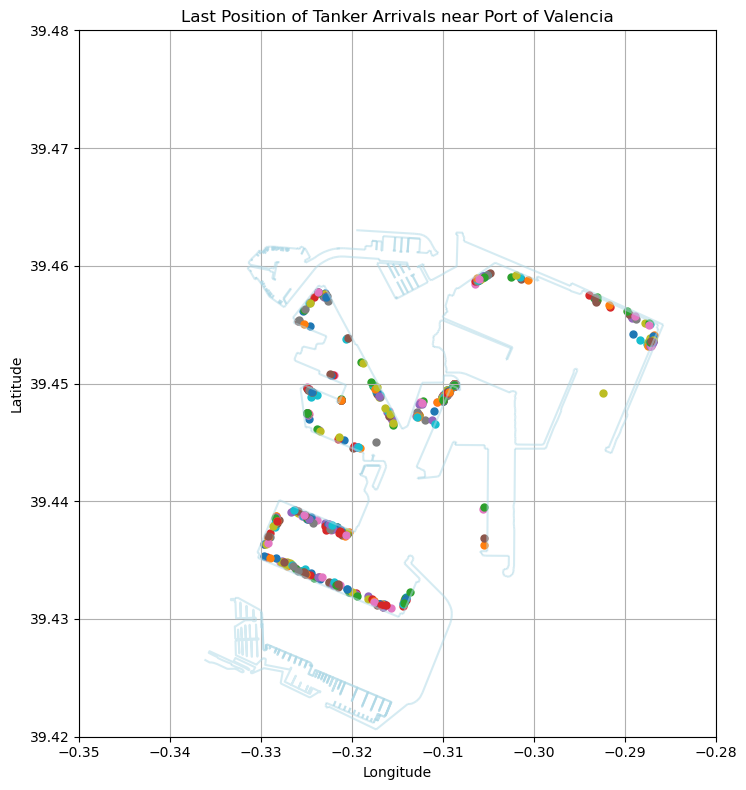

In [86]:
# Define zoom limits around Port of Valencia
lon_min, lon_max = -0.35, -0.28
lat_min, lat_max = 39.42, 39.48

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the port GeoDataFrame
port.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

# Plot each voyage using lat/lon
for voyage_id in Voyage_IDs_Tanker_Arrival:
    voyage_data = Sorted_Tanker_Arrival[Sorted_Tanker_Arrival['voyage_id'] == voyage_id]
    last_position = voyage_data.iloc[-1]
    ax.scatter(
        last_position['longitude'], 
        last_position['latitude'], 
        label=str(voyage_id),
        s=25  # size of marker
    )

# Set plot details
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_title('Last Position of Tanker Arrivals near Port of Valencia')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)
plt.tight_layout()
plt.show()

Above plot shows tankers being all over the port. It is worth noting that the plot shows voyages and not ships. Some of the ships are smaller tankers that serves as bunker barges, meaning they go alongside other vessels to deliver bunkers (fuel) to the other vessel, which may explain the frequent voyages to berths other than the tanker berths. If we for example look into the area bounded by 39.43 - 39.44 Latitude and -0.33 - -03.32 longitude and find the unique vessels within that area: 

In [87]:
subset = Sorted_Tanker_Arrival[
    (Sorted_Tanker_Arrival['latitude'] >= 39.43) &
    (Sorted_Tanker_Arrival['latitude'] <= 39.44) &
    (Sorted_Tanker_Arrival['longitude'] >= -0.33) &
    (Sorted_Tanker_Arrival['longitude'] <= -0.32)
]

print(subset['mmsi'].unique())

[224127820 352269000 210908000]


We see that there are 3 unique vessels within that area, MMSIs 224127820, 352269000 and 210908000. <br>However there is an error in the classification of tankers/containerships. When googling MMSI 352269000 it shows that this ship is in fact a MSC containership. <br>
Likewise when looking at the AIS data it is worth noting the "ship_type" column. The values of the "ship_type" column is part of the original AIS data transmitted by the ship and can be decoded using this list: https://api.vesselfinder.com/docs/ref-aistypes.html. <br> https://www.itu.int/rec/R-REC-m.1371/en contains the official standard for defining the vessel type, however the first link is easier accessible. 
The main point with regards to tankers is that a tanker vessel will transmit a "ship_type" code between 80-89. MMSI 352269000 has a code of 71 which indicates a Cargo vessel, Hazardous category A. <br> It is therefore necessary to create some method of checking the type of ship against the type specified in the AIS data from Awake, e.g. using the "ship_type" column. Which will be done below by taking the entire arrival dataset and subsetting for type codes between 80 - 89.

In [88]:
All_Tanker_Arrivals= Arrivals_AIS[Arrivals_AIS['ship_type'].between(80, 89)] #Find all ships transmitting a tanker code 
print(All_Tanker_Arrivals['vessel_type_details'].unique()) #Printer the type of ship specified via Awakes analysis/system


['Chemical Tanker' 'Tanker' '' 'LPG Carrier' 'Container Ship']


We see that there are ships transmitting type codes between 80-89 that have been classified as containerships and blanks ('') by the Awake system. We will investigate these further. <br> Initially we only consider ships transmitting a tanker code, that might not actually be tankers, meaning False Positives as these cases may add noisy data to our analysis. <br> We currently don't consider False Negatives, meaning actual tankers transmitting non-tanker codes, since these do not directly add noise to our tanker analysis, but can only add additional data. <br> If we were to consider False Negatives a good method would be to take all of the AIS data not transmitting tanker codes (80-89) and crosscheck for intersections with the tanker berth - This would narrow the potential population, which has to be crosschecked with MMSIs and manual google searches (for lack of a better method) considerably. 





These False & Positive Negatives might be caused by Awakes ship type classification process or the database they use as a reference. Alternatively it might be caused by incorrect setup during the installation of the vessels AIS system. <br>The type code transmitted by the ship is setup during the installation, so a containership transmitting a tanker code would have an incorrect type code set during installation. 

It also necessary to consider if we look at all tankers or we omit e.g. chemical tankers, LPG tankers etc. For now we continue with all of them. <br>First we clean the Arrivals and Departure dataset by subsetting for ship types between 80-89 and crossreferencing the MMSIs that the data from Awake classifies as being anything other than a tanker with a google search to determine actualy shop type.  

In [89]:
print(All_Tanker_Arrivals[All_Tanker_Arrivals['vessel_type_details']=='']['mmsi'].unique()) #Prints mmsi's where vessel_type_details are blank. 

[224805000 636093267 352003272 548748000 253000053 538011055 210324000]


A google search tells us that 253000053 is a sailing vessel. Which we will omit from the final dataset. Likewise we check for containerships. 

In [90]:
print(All_Tanker_Arrivals[All_Tanker_Arrivals['vessel_type_details']=='Container Ship']['mmsi'].unique()) #Prints mmsi's where vessel_type_details are container ship. 

[249197000]


A quick google search tells us that 249197000 is in fact a containership. We remove MMSIs 249197000 and 253000053 from the All_Tanker_Arrivals dataset. 

In [91]:
All_Tanker_Arrivals_filtered = All_Tanker_Arrivals[~All_Tanker_Arrivals['mmsi'].isin([249197000, 253000053])] #Removes noisy samples. 

We do the same procedure for the departure dataset.

In [92]:
All_Tanker_Departures= Departures_AIS[Departures_AIS['ship_type'].between(80, 89)]
print(All_Tanker_Departures['vessel_type_details'].unique())
print(All_Tanker_Departures[All_Tanker_Departures['vessel_type_details']=='']['mmsi'].unique()) #Prints mmsi's where vessel_type_details are blank. 
print(All_Tanker_Departures[All_Tanker_Departures['vessel_type_details']=='Container Ship']['mmsi'].unique()) #Prints mmsi's where vessel_type_details are container ship. 

['Chemical Tanker' 'Tanker' 'Container Ship' '' 'LPG Carrier']
[224805000 636093267 352003272 548748000 538011055 253000053 210324000]
[636021484 636022658 636092798 249197000]


MMSIs 253000053, 636021484, 636022658, 636092798, 249197000 will be removed. 

In [93]:
All_Tanker_Departures_filtered = All_Tanker_Departures[~All_Tanker_Departures['mmsi'].isin([253000053, 636021484, 636022658, 636092798, 249197000])] #Removes noisy samples. 

## Analysis and measurement of time spent at berth. 

To measure the time a tanker stays alongside the tanker berth for cargo operations we will use GeoPandas and MovingPandas for analysis. GeoPandas will be used to check when the vessel is within the polygon representing the tanker berths. MovingPandas will be used to measure the speed between subsequent positions, which will then be used as a measure of when the vessel is lying still within the polygon - it can also be used to compare with the speed over ground listed in the data. 
The dataset consist of arrival and departure voyages, we are interested in the time spent alongside the berth. This time we assume will be equal to the last data point of arrival voyage and the first point in the subsequent departure voyage (if it exists.)
<br> However given the data received from Awake and how they have processed it (specifically voyage status) the last data sample might not be the right sample to measure time alongside from, hence we need to assess the speeds.<br> I.e. the data from Awake may have e.g. 10 samples where the vessel is lying still before the final sample. So we need to use speed as a measure of when to start calculating time alongside. 

With the tanker data cleaned for non tankers we do some more pre-processing. 

Step 1 - Ensure the AIS data has a column with Point geometries, which enables operations between the position and GeoPandas functionalities.

In [94]:
# Create GeoDataFrame for arrivals
All_Tanker_Arrivals_filtered = All_Tanker_Arrivals_filtered.copy()
All_Tanker_Arrivals_filtered['geometry'] = All_Tanker_Arrivals_filtered.apply(
    lambda row: Point(row['longitude'], row['latitude']),
    axis=1
)

arrivals_gdf = gpd.GeoDataFrame(All_Tanker_Arrivals_filtered, geometry='geometry', crs="EPSG:4326")

# Create GeoDataFrame for departures
All_Tanker_Departures_filtered = All_Tanker_Departures_filtered.copy()
All_Tanker_Departures_filtered['geometry'] = All_Tanker_Departures_filtered.apply(
    lambda row: Point(row['longitude'], row['latitude']),
    axis=1
)
departures_gdf = gpd.GeoDataFrame(All_Tanker_Departures_filtered, geometry='geometry', crs="EPSG:4326")


Step 2 - Create a dictionary which maps a voyage ID with the corresponding subset of data including the voyage ID and subsequent voyage. Furthermore create a list of voyage IDs where a position intersects with the tanker berths. <br>Simultaneously calculate speed between subsequent positions (NOTE: Since there a data gaps these speeds might not be too reliable when looking at positions where the vessel is not lying still.)

In [95]:
# Create a dictionary to store the subsets
voyage_subsets = {}
tanker_berthstays = []

# First, find all unique voyage_ids
unique_voyages = arrivals_gdf['voyage_id'].unique() #Finds all the unique arrival voyage IDs for tankers

for voyage_id in tqdm(unique_voyages, desc="Processing voyages"):
    # Get all samples for this voyage
    arrival_voyage_samples = arrivals_gdf[arrivals_gdf['voyage_id'] == voyage_id]
    next_voyage_id = Arrivals_Meta[Arrivals_Meta['voyage_id'] == voyage_id]['next_voyage_id'].unique()
    
    if len(next_voyage_id) > 0:
        next_voyage_id = next_voyage_id[0]  # assuming only one next_voyage_id
        # Get samples for the next voyage
        next_voyage_samples = departures_gdf[departures_gdf['voyage_id'] == next_voyage_id]
        # Combine current and next voyage samples
        subset = pd.concat([arrival_voyage_samples, next_voyage_samples])
    else:
        subset = arrival_voyage_samples
    
    subset = subset.sort_values(by='pos_timestamp', ascending=True)

    #Use MovingPandas to calculate speed between subsequent positions. 
    trajectory = mp.Trajectory(subset, traj_id='subset_traj', t='pos_timestamp') #Create a trajectory object to calculate speeds between positions. 
    trajectory = trajectory.add_speed(name='speed_calc',units=("km","h"))  #Add the speed column - Speed is calculated between current and previous position, the first sample speed is set to be identical to the second sample. 
    trajectory.df['speed_calc'] = trajectory.df['speed_calc']*0.5399568035 #Change from km/h to knots
    trajectory.df['speed_calc'] = trajectory.df['speed_calc'].round(1)


    # Store in a dictionary
    voyage_subsets[voyage_id] = trajectory.df

    if subset.intersects(tanker_union).any():
        tanker_berthstays.append(voyage_id)

    

Processing voyages: 100%|██████████| 1606/1606 [01:38<00:00, 16.29it/s]


Step 3 - With the voyages that intersects the tanker berths found and the speed calculated we will generate a new dictionary which holds the voyage ID and the corresponding time spent at berth and store it in a dictionary. 

In [96]:
voyage_berth_time = {}
for voyage_id in tqdm(tanker_berthstays, desc='Finding time of berth stays'):
    subset = voyage_subsets[voyage_id].copy()

    condition = (subset['speed_calc']<0.3) & subset.intersects(tanker_union) #Mask which checks for rows where the speed is below 0.3 knots and the position intersects with the berth polygon. 0.3 is used instead of 0 to allow for some noise. 
    subset['stationary_at_berth'] = condition #Mask which sets True in column where condition is True
    
    subset['block'] = (subset['stationary_at_berth'] != subset['stationary_at_berth'].shift()).cumsum() #Adds a block counter where rows with identical value belongs to the same block. 
    
    # Store data for this voyage
    berth_stays = []

    for block_id, block_df in subset.groupby('block'):
        if block_df['stationary_at_berth'].iloc[0]:  # only interested in True blocks
            start_time = block_df.index.min()
            end_time = block_df.index.max()
            duration = end_time - start_time

            if duration >= timedelta(minutes=1):  # filter short stays
                berth_stays.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'duration': duration
                })

    if berth_stays:
        voyage_berth_time[voyage_id] = {
            'number_of_stays': len(berth_stays),
            'stays': berth_stays
        }


Finding time of berth stays: 100%|██████████| 1066/1066 [00:04<00:00, 213.76it/s]


Step 4 - Map each MMSI to the berthstays for that vessel. 

In [97]:
mmsi_to_berth_stays = {}

# Create a voyage_id ➝ MMSI mapping
voyage_to_mmsi = arrivals_gdf.drop_duplicates('voyage_id').set_index('voyage_id')['mmsi'].to_dict()

for voyage_id, berth_info in voyage_berth_time.items():
    mmsi = voyage_to_mmsi.get(voyage_id)
    if mmsi is not None:
        if mmsi not in mmsi_to_berth_stays:
            mmsi_to_berth_stays[mmsi] = []

        # Optionally include the voyage_id in the output
        for stay in berth_info['stays']:
            mmsi_to_berth_stays[mmsi].append({
                'voyage_id': voyage_id,
                'start_time': stay['start_time'],
                'end_time': stay['end_time'],
                'duration': stay['duration']
            })


records = []

for mmsi, stays in mmsi_to_berth_stays.items():
    for stay in stays:
        records.append({
            'mmsi': mmsi,
            'voyage_id': stay['voyage_id'],
            'start_time': stay['start_time'],
            'end_time': stay['end_time'],
            'duration': stay['duration'],  # timedelta format
            'duration_minutes': stay['duration'].total_seconds() / 60  # in minutes
        })

# Create DataFrame
berth_stays_df = pd.DataFrame(records)


Step 5 - Merge berthstays/MMSI and voyages together with vessel meta data. 

In [98]:
# List of columns you want to keep from arrival_ais
metadata_columns = [
    'mmsi',  # keep this for the merge
    'imo', 'name', 'build_year', 'length', 'width', 'flag',
    'manager', 'owner', 'class_society',
    'capacity_dwt', 'capacity_gt', 'capacity_nt',
    'capacity_liquid_gas', 'capacity_liquid_oil',
    'vessel_type_details', 'commercial_size_class',
    'draught_max', 'draught_min'
]

# Drop duplicates so you don't get multiple matches per MMSI
arrival_ais_unique = Arrivals_AIS[metadata_columns].drop_duplicates(subset='mmsi')

# Merge metadata into berth stays
berth_stays_merged = berth_stays_df.merge(arrival_ais_unique, on='mmsi', how='left')


In [99]:
display(berth_stays_merged.head(10))

,mmsi,voyage_id,start_time,end_time,duration,duration_minutes,imo,name,build_year,length,width,flag,manager,owner,class_society,capacity_dwt,capacity_gt,capacity_nt,capacity_liquid_gas,capacity_liquid_oil,vessel_type_details,commercial_size_class,draught_max,draught_min
0,224127820,016421a3-328a-434d-9271-b452d71370a7,2024-01-17 20:43:20,2024-01-18 15:30:51,0 days 18:47:31,1127.516667,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8
1,224127820,016421a3-328a-434d-9271-b452d71370a7,2024-01-18 16:03:30,2024-01-18 17:59:11,0 days 01:55:41,115.683333,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8
2,224127820,02786f0d-7e9e-4d5d-98c3-36b9edbb2684,2024-01-02 10:35:51,2024-01-02 17:36:50,0 days 07:00:59,420.983333,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8
3,224127820,064debe7-f8b6-4ad3-8eb1-60d83ed3c4dd,2024-01-15 16:51:19,2024-01-17 17:15:29,2 days 00:24:10,2904.166667,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8
4,224127820,07537ca0-dbc3-4a2e-8bd1-0f7560a24016,2024-01-25 20:58:21,2024-01-26 00:19:30,0 days 03:21:09,201.150000,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8
5,224127820,05d4f712-dcb8-475c-86d3-702e6d61f03b,2024-01-11 21:01:30,2024-01-11 22:55:39,0 days 01:54:09,114.150000,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8
6,224127820,05d4f712-dcb8-475c-86d3-702e6d61f03b,2024-01-12 03:44:39,2024-01-12 04:07:31,0 days 00:22:52,22.866667,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8
7,224127820,0a73b531-0a5a-4de2-af67-9a3d3c0e1e88,2024-01-13 18:45:21,2024-01-15 09:18:41,1 days 14:33:20,2313.333333,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8
8,224127820,0a81f994-0f00-4f58-8fc3-e88ea58fd75d,2024-01-31 16:58:10,2024-01-31 18:20:01,0 days 01:21:51,81.850000,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8
9,224127820,0a81f994-0f00-4f58-8fc3-e88ea58fd75d,2024-01-31 18:49:10,2024-01-31 20:21:21,0 days 01:32:11,92.183333,9312274,BAHIA UNO,2004,70.0,16.0,ES,NAVIERA MURUETA,Mureloil SA,BUREAU VERITAS,3808,2750,0,0,0,Tanker,HANDYSIZE,6.5,4.8


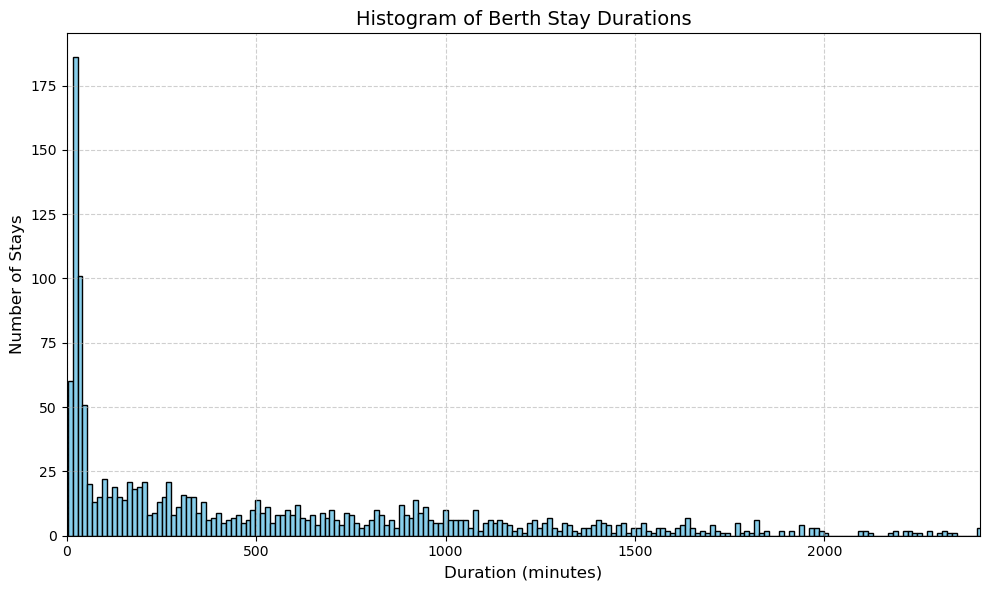

In [100]:
# Prepare data: use duration in minutes
durations = berth_stays_merged['duration_minutes']

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=500, color='skyblue', edgecolor='black')

# Labels and title
plt.title("Histogram of Berth Stay Durations", fontsize=14)
plt.xlabel("Duration (minutes)", fontsize=12)
plt.ylabel("Number of Stays", fontsize=12)

# Optional: limit x-axis to reduce effect of outliers
plt.xlim(0, durations.quantile(0.95))  # up to 95th percentile

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Functions for visualizing positions

In [102]:
def arrival_departure_port_plot(arrival_voyage_id, zoom = True):
    """
    Plots the Port of Valencia with berth types and the arrival/departure points for a specific voyage.

    Parameters:
    -----------
    arrival_voyage_id : int or str
        The unique identifier for the voyage used to determine arrival points.
        The corresponding departure points are inferred from the same subset.
    
    zoom : bool, optional (default=True)
        If True, the plot will zoom into the Port of Valencia for better visualization.

    Description:
    ------------
    This function visualizes the Port of Valencia with different berth types overlaid in distinct colors.
    It highlights the arrival and departure points of a selected test voyage using cyan and magenta markers.
    A custom legend is provided for clarity, and optional zooming focuses the view on the relevant port area.

    Notes:
    ------
    - Assumes that `voyage_subsets`, `port`, and various berth-type GeoDataFrames are defined globally.
    - Intended for visual inspection and validation of voyage data in port context.
    """

    subset = voyage_subsets[arrival_voyage_id]
    voyage_ids = subset['voyage_id'].unique()
    departure_id = voyage_ids[voyage_ids != arrival_voyage_id][0]    

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the port outline
    port.plot(ax=ax, color='black', edgecolor='black', linewidth=1)

    # Plot each berth type with a unique color
    tanker_berths.plot(ax=ax, color='blue', alpha=0.6)
    solid_bulk_berths.plot(ax=ax, color='saddlebrown', alpha=0.6)
    RoRo_berths.plot(ax=ax, color='orange', alpha=0.6)
    Passenger_berths.plot(ax=ax, color='purple', alpha=0.6)
    General_cargo_berths.plot(ax=ax, color='green', alpha=0.6)
    Container_berths.plot(ax=ax, color='red', alpha=0.6)

    # Plot test voyage arrival and departure points separately
    subset[subset['voyage_id']==arrival_voyage_id].plot(
        ax=ax, color='cyan', markersize=15, label='Arrival Points'
    )
    subset[subset['voyage_id']==departure_id].plot(
        ax=ax, color='magenta', markersize=15, label='Departure Points'
    )

    # Create custom legend
    legend_elements = [
        Patch(facecolor='black', edgecolor='black', label='Port Outline'),
        Patch(facecolor='blue', label='Tanker Berths'),
        Patch(facecolor='saddlebrown', label='Solid Bulk Berths'),
        Patch(facecolor='orange', label='Ro-Ro & Vehicle Berths'),
        Patch(facecolor='purple', label='Passenger Berths'),
        Patch(facecolor='green', label='General Cargo Berths'),
        Patch(facecolor='red', label='Container Berths'),
        Patch(facecolor='cyan', label='Arrival Points'),      # <-- Added
        Patch(facecolor='magenta', label='Departure Points')  # <-- Added
    ]

    # Add labels and legend
    ax.set_title("Port of Valencia - Berth Types and Test Voyages")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(handles=legend_elements, title="Legend", loc='best')
    ax.grid(True)

    if zoom:
        # Zoom into Port of Valencia
        ax.set_xlim([-0.34, -0.28])
        ax.set_ylim([39.42, 39.47])  
 


        

    plt.tight_layout()
    plt.show()

In [103]:
def time_gradient_port_plot(arrival_voyage_id, zoom=True):
    """
    Plots vessel positions for a given voyage over the Port of Valencia, using a color gradient to represent time.

    Parameters:
    -----------
    arrival_voyage_id : int or str
        The unique identifier for the voyage whose positions over time will be visualized.
    
    zoom : bool, optional (default=True)
        If True, the plot view will be zoomed in on the Port of Valencia for better detail.

    Description:
    ------------
    This function creates a geospatial plot of the Port of Valencia, showing berth types and
    vessel position data for a specified voyage. Each point in the voyage is color-coded
    using a continuous gradient based on its timestamp, allowing temporal patterns to be visualized.

    The port layout and berth categories are overlaid in distinguishable colors. A color bar is
    included to indicate the timestamp scale in seconds since the Unix epoch.

    Notes:
    ------
    - Assumes that `voyage_subsets`, `port`, and individual berth-type GeoDataFrames are defined in the global scope.
    - Timestamp values are derived from the index of the GeoDataFrame and should be datetime-like.
    - Uses the 'plasma' colormap by default; this can be changed for different visual effects.
    """

    subset = voyage_subsets[arrival_voyage_id]


    # Convert timestamp to numeric format (milliseconds since the Unix epoch)
    subset['timestamp_numeric'] = subset.index.astype(np.int64) / 10**9  # Convert to seconds

   
    # Normalize the timestamps to a range of 0 to 1
    norm = plt.Normalize(subset['timestamp_numeric'].min(), subset['timestamp_numeric'].max())
    cmap = cm.plasma  # You can change this to other colormaps like 'plasma', 'coolwarm', etc.
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the port outline
    port.plot(ax=ax, color='black', edgecolor='black', linewidth=1)

    # Plot each berth type with a unique color
    tanker_berths.plot(ax=ax, color='blue', alpha=0.6)
    solid_bulk_berths.plot(ax=ax, color='saddlebrown', alpha=0.6)
    RoRo_berths.plot(ax=ax, color='orange', alpha=0.6)
    Passenger_berths.plot(ax=ax, color='purple', alpha=0.6)
    General_cargo_berths.plot(ax=ax, color='green', alpha=0.6)
    Container_berths.plot(ax=ax, color='red', alpha=0.6)

    # Plot arrival and departure points with color gradient based on timestamp
    scatter_arrival = ax.scatter(
        subset['longitude'], subset['latitude'], 
        c=subset['timestamp_numeric'], cmap=cmap, norm=norm, 
        s=30, label='Positions', edgecolors='black', alpha=0.7
    )
    
    # Create color bar based on timestamp
    cbar = plt.colorbar(scatter_arrival, ax=ax)
    cbar.set_label('Timestamp in seconds from datum')

    # Create custom legend
    legend_elements = [
        Patch(facecolor='black', edgecolor='black', label='Port Outline'),
        Patch(facecolor='blue', label='Tanker Berths'),
        Patch(facecolor='saddlebrown', label='Solid Bulk Berths'),
        Patch(facecolor='orange', label='Ro-Ro & Vehicle Berths'),
        Patch(facecolor='purple', label='Passenger Berths'),
        Patch(facecolor='green', label='General Cargo Berths'),
        Patch(facecolor='red', label='Container Berths'),
        Patch(facecolor='cyan', label='Arrival Points'),  # <-- Added
        Patch(facecolor='magenta', label='Departure Points')  # <-- Added
    ]

    # Add labels and legend
    ax.set_title("Port of Valencia - Berth Types and Test Voyages")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(handles=legend_elements, title="Legend", loc='best')
    ax.grid(True)

    if zoom:
        # Zoom into Port of Valencia
        ax.set_xlim([-0.34, -0.28])
        ax.set_ylim([39.42, 39.47])

    plt.tight_layout()
    plt.show()

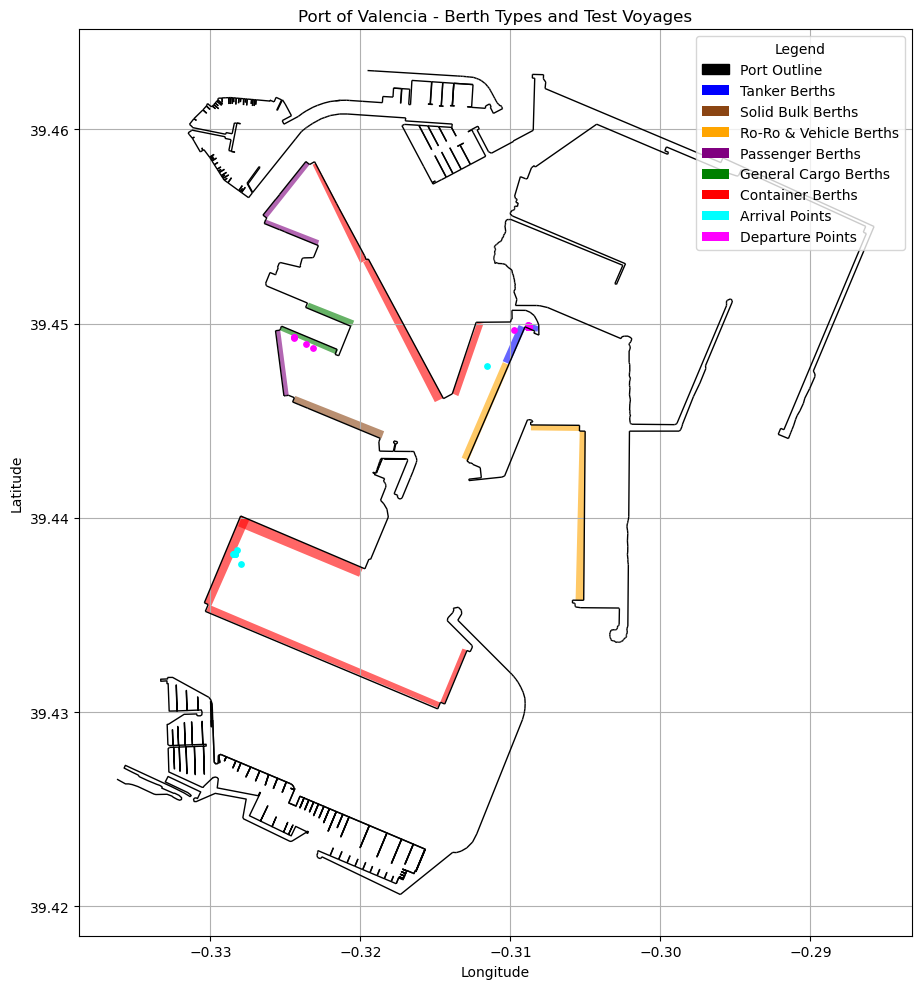

In [104]:
arrival_departure_port_plot('e3c15c51-8418-435f-8d8f-2daf1aba0b0e', False)
    

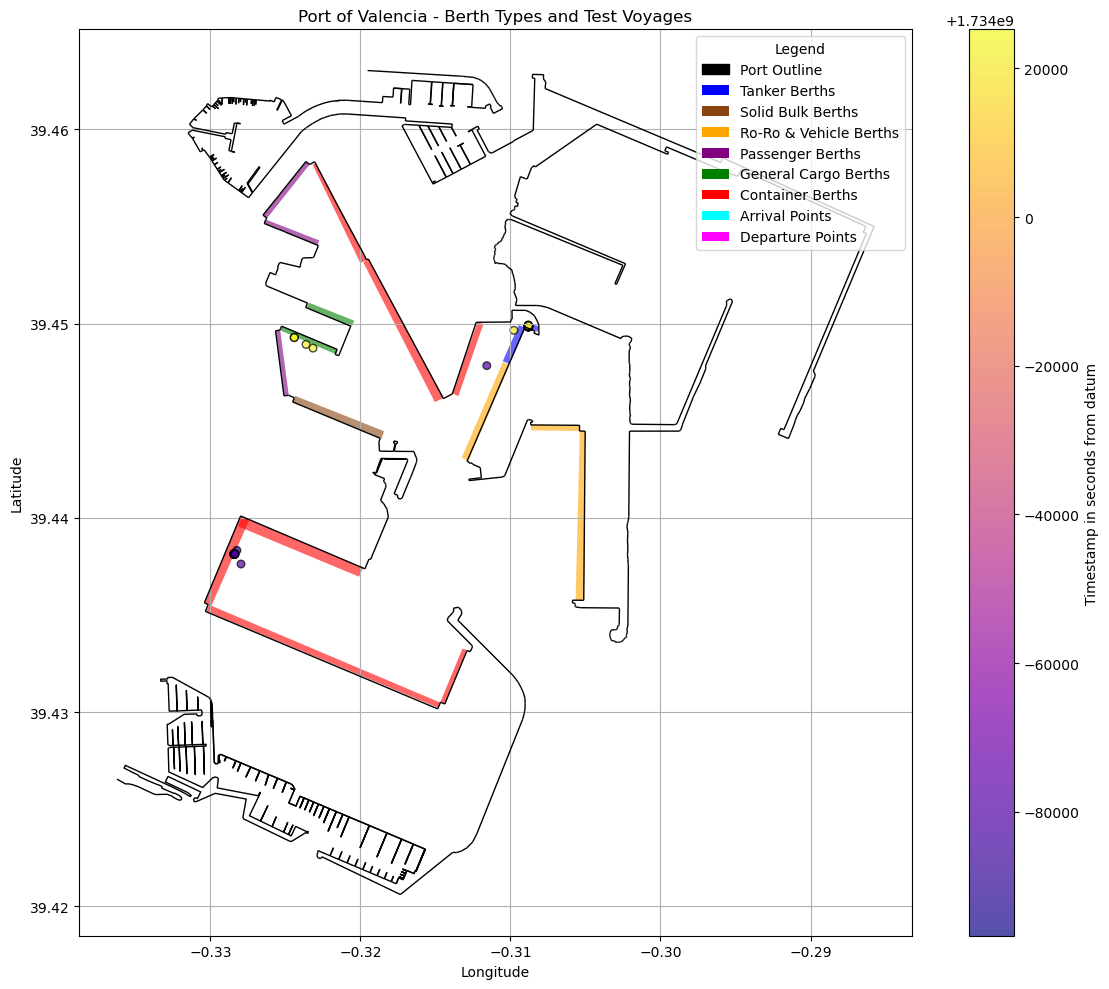

In [105]:
time_gradient_port_plot('e3c15c51-8418-435f-8d8f-2daf1aba0b0e', False)